# Abstraction Alignment to Interpret a CIFAR-100 Model
We apply abstraction alignment to interpret a CIFAR-100 image classification model using the CIFAR-100 class-superclass hierarchy as the human abstraction graph. This example is loosly based on the Interpreting Image Model Behavior case study in the Abstraction Alignment paper (Section 5.1).

In this notebook, we train and evaluate a ResNet20 on CIFAR-100. We use the abstraction alignment methodology to aggregate and report the model's abstraction match and qualitatively analyze common "types" of abstraction (mis)alignment.

Note: the values in this notebook may differ slightly from the values in the interface due to differences in normalization and thresholding. The relative values and takeaways remain the same.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import altair as alt
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from itertools import combinations

from abstraction_graph_cifar import make_abstraction_graph, show_abstraction_graph, propagate
import util.cifar.cifar_util as cifar_util
import util.cifar.cifar_train as cifar_train
import util.cifar.cifar_metadata as cifar_metadata

import metrics

sns.set_style("whitegrid")

## CIFAR-100 Model and Dataset
First, we load the CIFAR-100 dataset and train a ResNet20 on it. This is the model we will inspect with abstraction alignment.

In [3]:
# User-defined paths -- TODO: update with your own
MODEL_PATH = 'util/cifar/'
CIFAR_DIR = '/nobackup/users/aboggust/data/cifar'

In [4]:
# Train a ResNet20 on CIFAR-100
batch_size = 128
data_augmentation = True
epochs = 200
architecture = 'resnet20'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = os.path.join(MODEL_PATH, architecture, 'checkpoints', 'checkpoint.pt')
if os.path.isfile(checkpoint):
    print(f'Loading trained CIFAR-100 model from: {checkpoint}')
    model = cifar_util.load_model(architecture)
    model.load_state_dict(torch.load(checkpoint))
else:
    print(f'Training CIFAR-100 model')
    model = cifar_train.train(
        architecture, 
        batch_size, 
        epochs, 
        CIFAR_DIR,
        MODEL_PATH,
        data_augmentation
    )
    
model.to(device)
model = model.eval()

Loading trained CIFAR-100 model from: util/cifar/resnet20/checkpoints/checkpoint.pt


In [5]:
# Load the CIFAR-100 dataset for exploration
train_loader, test_loader = cifar_util.load_dataset(CIFAR_DIR, 
                                                    data_augmentation,
                                                    batch_size)
test_dataset = test_loader.dataset

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Compute model outputs on test instances
labels = []
outputs = []
for i, (image, label) in enumerate(tqdm(test_loader)):
    with torch.no_grad():
        images = image.to(device)
    labels.extend(label.numpy())
    output = model(images)
    output = torch.nn.functional.softmax(output, dim=1).detach().cpu().numpy()
    outputs.append(output)
outputs = np.vstack(outputs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 14.70it/s]


In [7]:
# Print model performance statistics
predictions = [np.argmax(output) for output in outputs]
correctness = [label == predictions[i] for i, label in enumerate(labels)]
correct_inds = [i for i, label in enumerate(labels) if label == predictions[i]]
incorrect_inds = [i for i, label in enumerate(labels) if label != predictions[i]]
print(f'MODEL STATS:')
print(f'Accuracy: {len(correct_inds) / len(labels):.2%}')
print(f'Mean prediction confidence: {np.mean([np.max(output) for output in outputs]):.2f}')
print(f'Mean prediction confidence (correct): {np.mean([np.max(outputs[i]) for i in correct_inds]):.2f}')
print(f'Mean prediction confidence (incorrect): {np.mean([np.max(outputs[i]) for i in incorrect_inds]):.2f}')

MODEL STATS:
Accuracy: 67.68%
Mean prediction confidence: 0.78
Mean prediction confidence (correct): 0.87
Mean prediction confidence (incorrect): 0.59


## Compute Abstraction Alignment
We use abstraction alignment to analyze how well the human abstractions account for the model's behavior.

### Load the human abstraction graph (i.e., the CIFAR-100 class and superclass hiearchy)
The human abstraction graph represents human concepts and the relationships between them.

In [8]:
abstraction_graph = make_abstraction_graph()
print(f'CIFAR-100 abstraction_graph with {abstraction_graph.size()} nodes across {abstraction_graph.depth() + 1} levels.')
print(show_abstraction_graph(abstraction_graph))

CIFAR-100 abstraction_graph with 121 nodes across 3 levels.
root
├── aquatic_mammals
│   ├── beaver
│   ├── dolphin
│   ├── otter
│   ├── seal
│   └── whale
├── fish
│   ├── aquarium_fish
│   ├── flatfish
│   ├── ray
│   ├── shark
│   └── trout
├── flowers
│   ├── orchid
│   ├── poppy
│   ├── rose
│   ├── sunflower
│   └── tulip
├── food_containers
│   ├── bottle
│   ├── bowl
│   ├── can
│   ├── cup
│   └── plate
├── fruit_and_vegetables
│   ├── apple
│   ├── mushroom
│   ├── orange
│   ├── pear
│   └── sweet_pepper
├── household_electrical_devices
│   ├── clock
│   ├── keyboard
│   ├── lamp
│   ├── telephone
│   └── television
├── household_furniture
│   ├── bed
│   ├── chair
│   ├── couch
│   ├── table
│   └── wardrobe
├── insects
│   ├── bee
│   ├── beetle
│   ├── butterfly
│   ├── caterpillar
│   └── cockroach
├── large_carnivores
│   ├── bear
│   ├── leopard
│   ├── lion
│   ├── tiger
│   └── wolf
├── large_man-made_outdoor_things
│   ├── bridge
│   ├── castle
│   ├── house
│   ├─

### Create the model's fitted abstractions
The model's fitted abstractions are a weighted version of the abstraction graph for each model decision. The value of each node represents the model's confidence in that concept. If it is a leaf node, then the value is the model's confidence in that decision. If it is an internal node, then the value is the sum of the model's confidence across its reacahble leaves.

In [9]:
# Create the model's fitted abstractions for each instance by propagating model outputs through the abstraction graph
fitted_abstractions = []
for i in tqdm(range(len(labels))):
    fitted_abstraction = propagate(outputs[i], make_abstraction_graph())
    fitted_abstractions.append(fitted_abstraction)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:10<00:00, 76.73it/s]


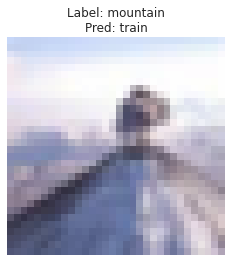

TOP PREDICTED CLASSES:  ['train (0.37)', 'road (0.18)', 'spider (0.17)']
FITTED ABSTRACTION:
root (1.00)
├── aquatic_mammals (0.03)
│   ├── seal (0.02)
├── household_furniture (0.01)
│   ├── couch (0.01)
├── insects (0.03)
│   └── cockroach (0.03)
├── large_man-made_outdoor_things (0.20)
│   ├── bridge (0.01)
│   ├── road (0.18)
│   └── skyscraper (0.01)
├── large_natural_outdoor_scenes (0.01)
├── large_omnivores_and_herbivores (0.01)
├── non-insect_invertebrates (0.17)
│   ├── spider (0.17)
├── people (0.01)
│   ├── girl (0.01)
├── trees (0.12)
│   ├── palm_tree (0.12)
├── vehicles_1 (0.37)
│   └── train (0.37)
└── vehicles_2 (0.04)
    ├── streetcar (0.04)



In [10]:
# Show an example fitted abstraction
index = 0

image = test_dataset[index][0].permute(1, 2, 0)
plt.imshow(cifar_util.unnorm_cifar_image(image))
plt.axis('off')
plt.title(f'Label: {cifar_metadata.CLASS_LABELS[labels[index]]}\nPred: {cifar_metadata.CLASS_LABELS[predictions[index]]}')
plt.show()

top_predictions = np.argsort(outputs[index])[-3:]
print('TOP PREDICTED CLASSES: ', [f'{cifar_metadata.CLASS_LABELS[i]} ({outputs[index][i]:.2f})' for i in top_predictions][::-1])

print('FITTED ABSTRACTION:')
print(show_abstraction_graph(fitted_abstractions[0]))

### Abstraction Match
Abstraction match measures how much moving up one level of abstraction reduces the model's entropy. If the abstraction match is high (e.g., a lot of entropy is reduced), that is a signal that the model has learned those abstractions.

In [11]:
# Compute level-1 abstraction match aggregated per level-1 concept
instance_per_concept = {}
for i, label in enumerate(labels):
    label_concept = cifar_metadata.CLASS_TO_SUPERCLASS[label]
    if label_concept not in instance_per_concept:
        instance_per_concept[label_concept] = set([])
    instance_per_concept[label_concept].add(i)

# Compute abstraction match per leve-1 concept
level_1_concept_abstraction_match = {}
for concept, instances in tqdm(instance_per_concept.items()):
    instance_fitted_abstractions = [fitted_abstraction for i, fitted_abstraction in enumerate(fitted_abstractions) if i in instances]
    match = metrics.abstraction_match(instance_fitted_abstractions, 1)
    level_1_concept_abstraction_match[concept] = match
        
# Plot abstraction match
ordered_concepts = sorted(level_1_concept_abstraction_match.keys(), key=lambda c: level_1_concept_abstraction_match[c], reverse=True)
df = pd.DataFrame.from_dict({
    'concept': [cifar_metadata.SUPERCLASS_LABELS[concept] for concept in ordered_concepts],
    'abstraction match': [level_1_concept_abstraction_match[concept] for concept in ordered_concepts],
})
alt.Chart(df, title='Abstraction Match per Superclass').mark_bar().encode(
    x=alt.X('concept:N').sort('-y'),
    y=alt.Y('abstraction match:Q'),
    color=alt.Color('concept:N'),
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:37<00:00,  1.89s/it]


alt.Chart(...)

### Query for model behavior types
We can use abstraction alignment to query for common pattens in model behavior. We define a query over the fitted abstractions and return all the instances that match.

In [12]:
def show_examples(indicies, num_examples):
    if len(indicies) > 0:
        example_inds = np.random.choice(indicies, num_examples)
        plot_images(example_inds)
        plt.show()
        print(show_abstraction_graph(fitted_abstractions[example_inds[0]]))

def plot_images(indicies):
    fig, ax = plt.subplots(nrows=1, ncols=len(indicies))
    if type(ax) != list:
        ax = [ax]
    for i, index in enumerate(indicies):
        ax[i].imshow(cifar_util.unnorm_cifar_image(test_dataset[index][0].permute(1, 2, 0)))
        ax[i].axis('off')
    return fig

def get_nodes_at_level(abstraction_graph, level, non_zero=True):
    nodes = abstraction_graph.filter_nodes(lambda x: abstraction_graph.depth(x) == level)
    if non_zero:
        nodes = [node for node in nodes if node.data is not None and node.data >= 0.01]
    return nodes

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 816.99it/s]


2976 images where the model is fully confident in one output concept.


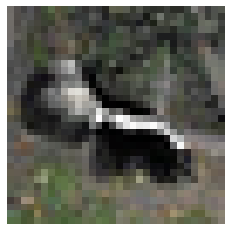

root (1.00)
├── medium_mammals (1.00)
│   └── skunk (1.00)



In [13]:
# Fully confident in an output concept
fully_confident = []
for i, fitted_abstraction in enumerate(tqdm(fitted_abstractions)):
    non_zero_leaf_nodes = get_nodes_at_level(fitted_abstraction, 2, True)
    if len(non_zero_leaf_nodes) == 1:
        fully_confident.append(i)
print(f'{len(fully_confident)} images where the model is fully confident in one output concept.')
show_examples(fully_confident, 1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 261.59it/s]


19 images where the model is split between two branches through two superclass.


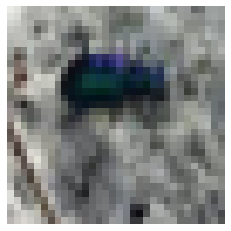

root (1.00)
├── insects (0.49)
│   ├── beetle (0.49)
├── large_carnivores (0.50)
│   └── wolf (0.50)



In [14]:
# Confidence split between two independent branches
two_branches = []
for i, fitted_abstraction in enumerate(tqdm(fitted_abstractions)):
    non_zero_level_1_nodes = get_nodes_at_level(fitted_abstraction, 1, True)
    non_zero_leaf_nodes = get_nodes_at_level(fitted_abstraction, 2, True)
    if len(non_zero_leaf_nodes) != 2 or len(non_zero_level_1_nodes) != 2:
        continue
    if 0.45 <= np.max([node.data for node in non_zero_leaf_nodes]) <= 0.55 and 0.45 <= np.max([node.data for node in non_zero_level_1_nodes]) <= 0.55:
        two_branches.append(i)

print(f'{len(two_branches)} images where the model is split between two branches through two superclass.')
show_examples(two_branches, 1)

### Concept Co-Confusion
We can also use abstraction alignment to indentify pairs of concepts that the model commonly confuses. These concepts can help us identify misalignments between human-similar concepts and model-similar concepts.

In [15]:
coconfusion = metrics.concept_coconfusion(fitted_abstractions, 0.00001)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [13:48<00:00, 12.08it/s]


In [18]:
# Highest overall confusion
coconfusion_non_root = {k:v for k, v in coconfusion.items() if 'root' not in k}
sorted_pairs = [k for k, v in sorted(coconfusion.items(), key=lambda item: item[1], reverse=True)]
print('HIGHEST OVERALL COCONFUSION:')
for i in range(5):
    print(f'{sorted_pairs[i]} --- {coconfusion[sorted_pairs[i]]:.2%}')

HIGHEST OVERALL COCONFUSION:
couch,household_furniture --- 30.58%
household_electrical_devices,lamp --- 29.65%
fruit_and_vegetables,mushroom --- 29.52%
food_containers,household_electrical_devices --- 29.37%
medium_mammals,small_mammals --- 29.00%


In [19]:
# Confusion between superclass nodes
superclass_pairs = [pair for pair in sorted_pairs if pair.split(',')[0] in cifar_metadata.SUPERCLASS_LABELS and pair.split(',')[1] in cifar_metadata.SUPERCLASS_LABELS]
print('HIGHEST SUPERCLASS COCONFUSION:')
for i in range(5):
    print(f'{superclass_pairs[i]} --- {coconfusion[superclass_pairs[i]]:.2%}')

HIGHEST SUPERCLASS COCONFUSION:
food_containers,household_electrical_devices --- 29.37%
medium_mammals,small_mammals --- 29.00%
non-insect_invertebrates,reptiles --- 28.76%
vehicles_1,vehicles_2 --- 28.32%
insects,non-insect_invertebrates --- 28.31%
